# MPPT Data Analysis

Data acquisition: Annick Dewald

Analysis: Peter Sharpe

## Setup

Imports:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

Extract data:

In [2]:
data_raw = pd.read_excel("OTS_MPPTs.xlsx")

Clean data:

In [3]:
data_all = data_raw.iloc[1:]  # strip units
data_all.columns = [name.lower().strip() for name in data_all.columns]

Write a function to parse data, depending on what you care about:

In [4]:
from typing import List


def get_data(important_columns: List[str] = None):
    if important_columns is None:
        important_columns = [
            "name",
            "max solar input power",
            "price",
            "peak conversion efficiency",
            "dimensions",
            "weight",
        ]
    data = data_all[important_columns]
    data = data.dropna(inplace=False)
    return data

## Power vs. Mass

Get data:

In [5]:
data = get_data(
    [
        "max solar input power",
        "weight",
    ]
)
powers = data["max solar input power"].to_numpy()
masses = data["weight"].to_numpy()

Regress a model:

In [6]:
from aerosandbox.tools import fitting as fit

model = lambda x, p: p["constant"] * x["power"] ** p["exponent"]

params = fit.fit(
    model=model,
    x_data={"power": powers},
    y_data=masses,
    param_guesses={
        "constant": 1,
        "exponent": 1,
    },
    put_residuals_in_logspace=True,
)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

Plot:

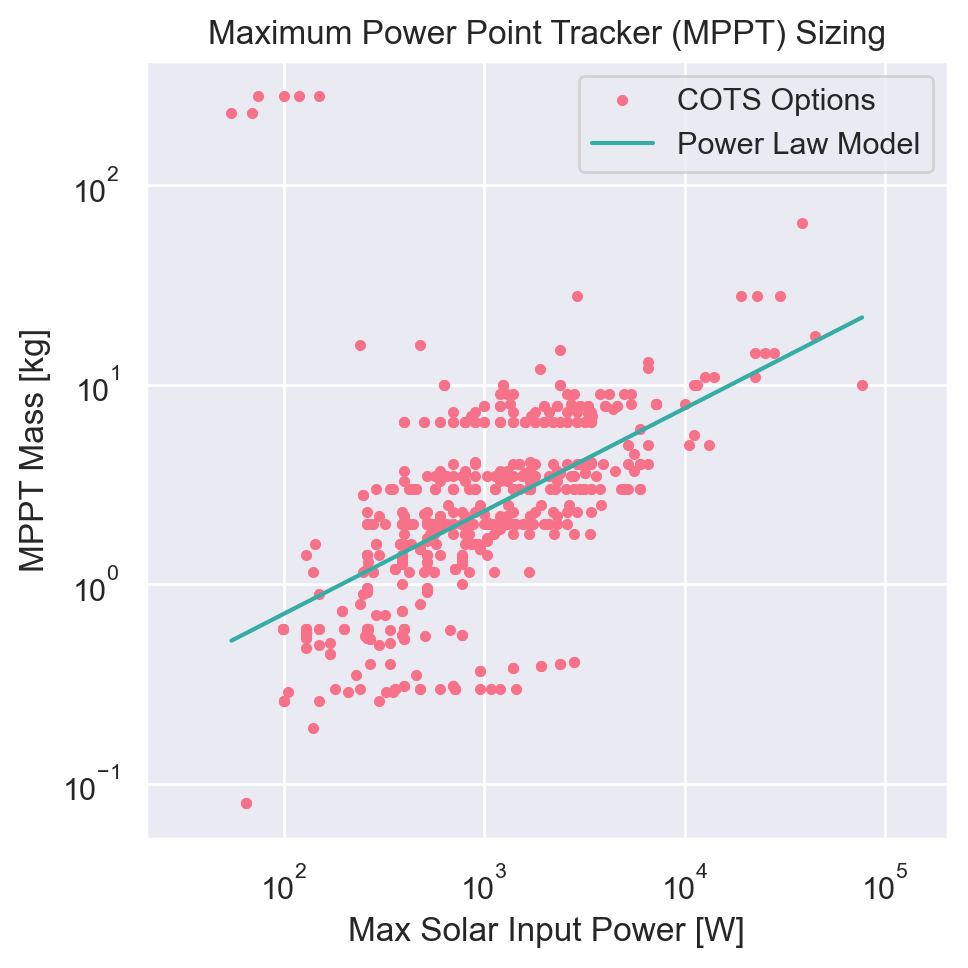

In [7]:
sns.set(palette=sns.color_palette("husl", 2))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

# Plot data
plt.loglog(powers, masses, ".", label="COTS Options")

# Plot model
power_model = np.logspace(np.log10(np.min(powers)), np.log10(np.max(powers)), 500)
mass_model = model({"power": power_model}, params)
plt.plot(
    power_model,
    mass_model,
    "-",
    label="Power Law Model",
)

plt.axis("equal")
plt.xlabel(r"Max Solar Input Power [W]")
plt.ylabel(r"MPPT Mass [kg]")
plt.title(r"Maximum Power Point Tracker (MPPT) Sizing")
plt.tight_layout()
plt.legend()
# plt.savefig("C:/Users/User/Downloads/temp.svg")
plt.show()

## Secondary Factor Analysis

We notice that there's a lot of variation in MPPT mass - perhaps this has to do with efficiency?

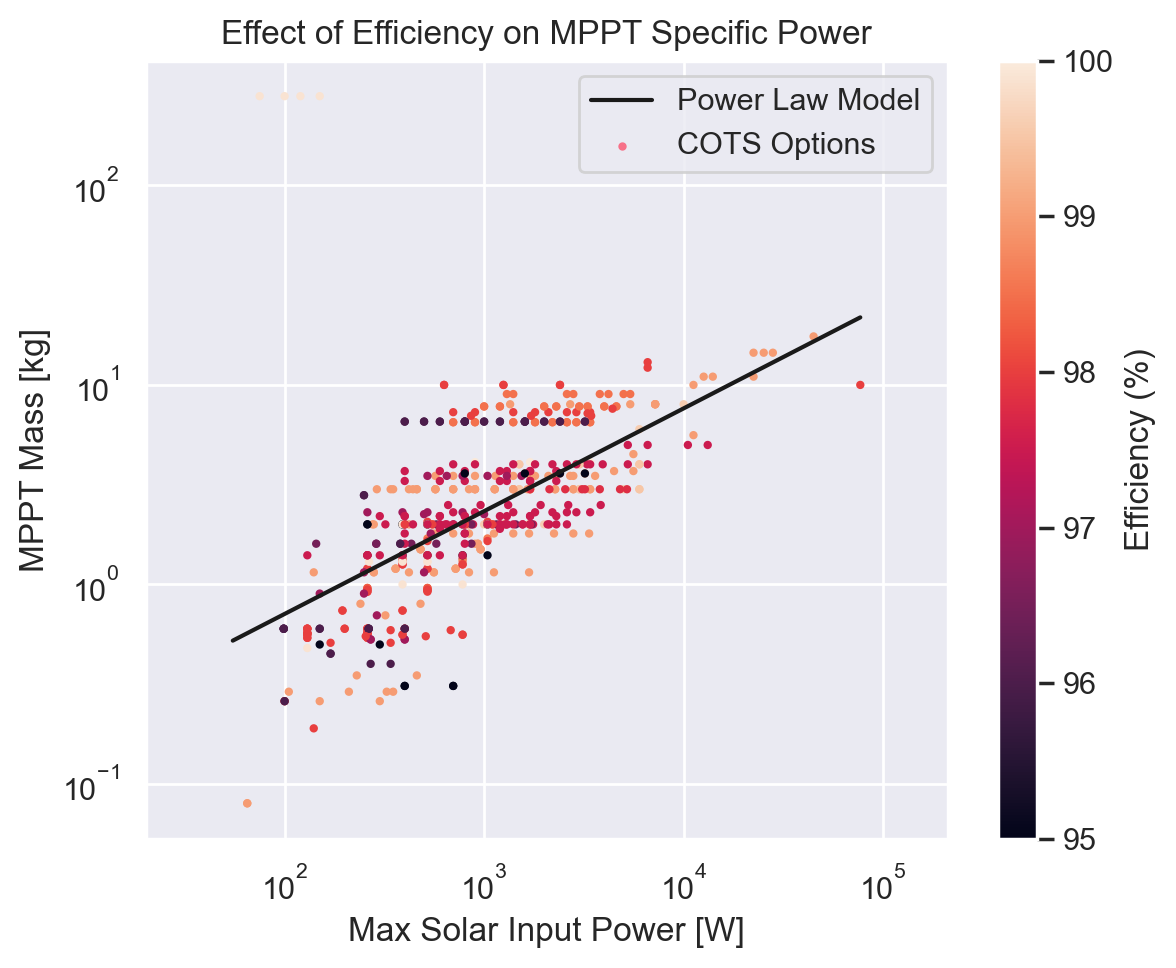

In [8]:
data = get_data(["max solar input power", "peak conversion efficiency", "weight"])
powers = data["max solar input power"].to_numpy()
masses = data["weight"].to_numpy()
efficiencies = data["peak conversion efficiency"].to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=200)

# Plot data
plt.scatter(powers, masses, s=4, c=efficiencies, label="COTS Options")

# Plot model
plt.loglog(
    power_model,
    mass_model,
    "-k",
    label="Power Law Model",
)
plt.clim(95, 100)
plt.axis("equal")
plt.xlabel(r"Max Solar Input Power [W]")
plt.ylabel(r"MPPT Mass [kg]")
plt.title(r"Effect of Efficiency on MPPT Specific Power")
plt.tight_layout()
plt.legend()
plt.colorbar().set_label("Efficiency (%)")
# plt.savefig("C:/Users/User/Downloads/temp.svg")
plt.show()

Hmmm. It doesn't look like there's a strong correlation between specific power and efficiency.

Maybe price is the differentiating factor?

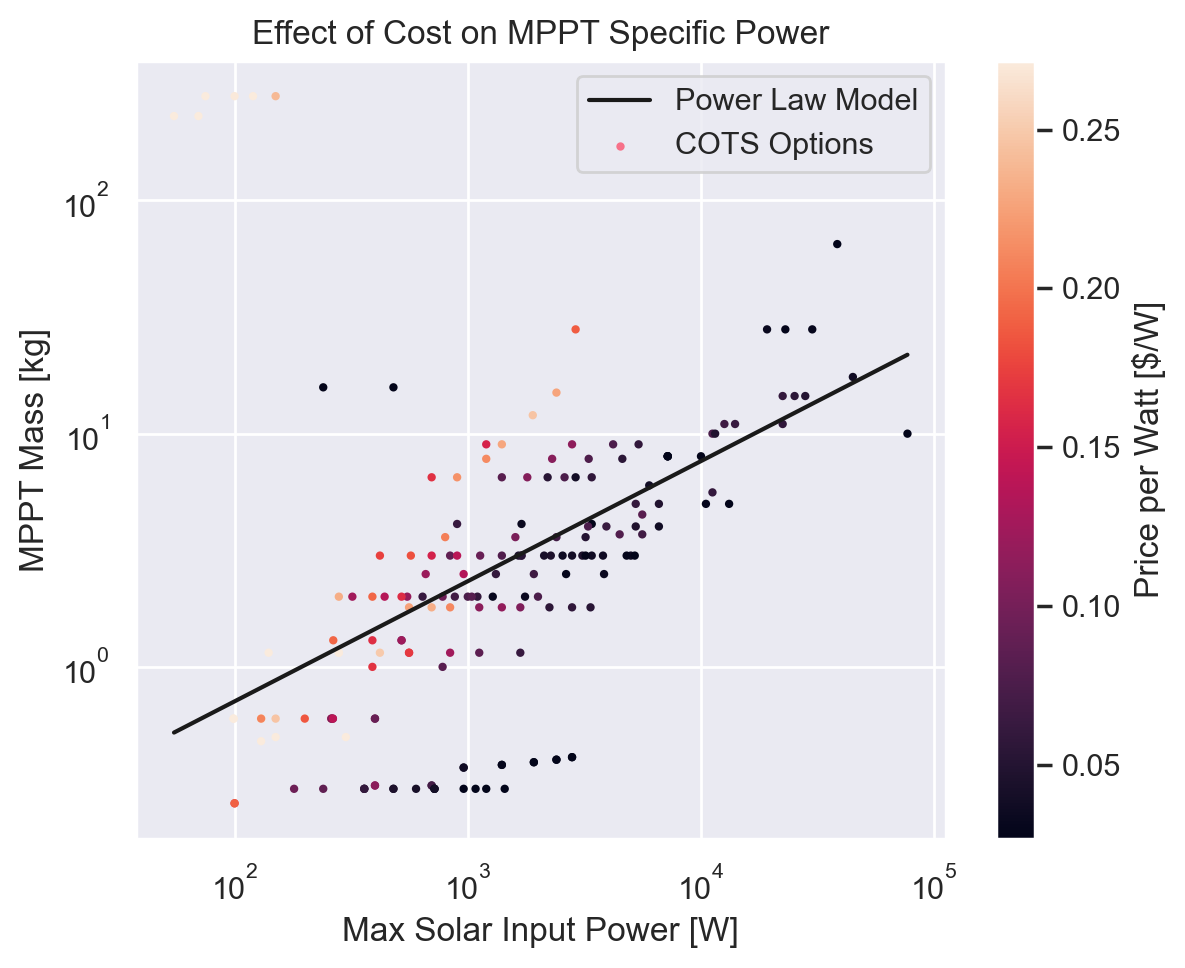

In [9]:
data = get_data(["max solar input power", "price", "weight"])
powers = data["max solar input power"].to_numpy()
masses = data["weight"].to_numpy()
prices = data["price"].to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=200)

# Plot data
plt.scatter(powers, masses, s=4, c=prices / powers, label="COTS Options")

# Plot model
plt.loglog(
    power_model,
    mass_model,
    "-k",
    label="Power Law Model",
)
plt.clim(np.percentile(prices / powers, q=(10, 90)))
plt.axis("equal")
plt.xlabel(r"Max Solar Input Power [W]")
plt.ylabel(r"MPPT Mass [kg]")
plt.title(r"Effect of Cost on MPPT Specific Power")
plt.tight_layout()
plt.legend()
plt.colorbar().set_label("Price per Watt [$/W]")
# plt.savefig("C:/Users/User/Downloads/temp.svg")
plt.show()

Power-specific cost seems like it might be playing a role in where we fall along the curve, but in the wrong direction - cheaper MPPTs have better specific power. Strange!